In [1]:
# Dependencies
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import time
from datetime import datetime, date
from dateutil.relativedelta import relativedelta, MO
import matplotlib.pyplot as plt
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"
#https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey
company = "Netflix"

In [2]:
# Search for articles that mention company name
query = company

In [3]:
# Build query URL
query_url = url +"q=" + query + "&fq=news_desk:(Business)&page=0&sort=newest&api-key=" + api_key
#print(query_url)

In [30]:
# Request articles
articles = requests.get(query_url).json()

# The "response" property in articles contains the actual articles
# list comprehension.
articles_list = articles["response"]["docs"]


In [31]:
# Store top 5 articles urls and names
web_urls = []
for article in articles_list[:5]:
    web_urls.append("https://www.nytimes.com/" + article["multimedia"][0]["url"])
article_names = []

for article in articles_list[:5]:
    article_names.append(article["headline"]["main"])
    
article_image_urls = []
for x in range(len(web_urls)):
    article_image_urls.append({'title':article_names[x], 'img_url': web_urls[x]})

In [32]:
article_image_urls

[{'title': 'Quibi Is Dead, but Roku May Resurrect Its Content',
  'img_url': 'https://www.nytimes.com/images/2021/01/04/business/04ECON-BRIEFING-QUIBI/04ECON-BRIEFING-QUIBI-articleLarge.jpg'},
 {'title': 'Will You Pay to Stream Comfort Shows? Discovery Is About to Find Out',
  'img_url': 'https://www.nytimes.com/images/2021/01/04/business/00JPDiscovery-streaming1-print/merlin_181779237_fe8bf584-1aa6-4967-ac0c-1826d3f6342d-articleLarge.jpg'},
 {'title': 'A Sci-Fi Dreamer’s Poisoning Death Shocks China',
  'img_url': 'https://www.nytimes.com/images/2021/01/02/business/31JPchina-poison-print/merlin_181829496_6986f26c-9eb9-4132-b3e0-8145649fefb2-articleLarge.jpg'},
 {'title': 'Managing Movie Superheroes Is About to Get a Lot More Complicated',
  'img_url': 'https://www.nytimes.com/images/2020/12/27/business/27superheroes-1/27superheroes-1-articleLarge-v2.jpg'},
 {'title': 'An Oscar Winner Made a Khashoggi Documentary. Streaming Services Didn’t Want It.',
  'img_url': 'https://www.nytimes.c

In [33]:
feature_article = articles_list[0]

In [34]:
feature_article_url = feature_article["web_url"]
feature_article_name = feature_article["headline"]["main"]
feature_image_link = "https://www.nytimes.com/" + feature_article["multimedia"][0]["url"]
feature_article_lead = feature_article["lead_paragraph"]

In [35]:
stock_data = {
"feature_title": feature_article_name,
"feature_p": feature_article_lead,
"feature_link": feature_article_url,
"featured_image_url": feature_image_link,
"article_image_urls": article_image_urls
}

In [36]:
stock_data

{'feature_title': 'Quibi Is Dead, but Roku May Resurrect Its Content',
 'feature_p': 'Quibi was the biggest bust of the streaming boom. But it has something Roku wants — more than 100 original programs.',
 'feature_link': 'https://www.nytimes.com/2021/01/04/business/media/04economy-briefing-quibi-sale-content-roku.html',
 'featured_image_url': 'https://www.nytimes.com/images/2021/01/04/business/04ECON-BRIEFING-QUIBI/04ECON-BRIEFING-QUIBI-articleLarge.jpg',
 'article_image_urls': [{'title': 'Quibi Is Dead, but Roku May Resurrect Its Content',
   'img_url': 'https://www.nytimes.com/images/2021/01/04/business/04ECON-BRIEFING-QUIBI/04ECON-BRIEFING-QUIBI-articleLarge.jpg'},
  {'title': 'Will You Pay to Stream Comfort Shows? Discovery Is About to Find Out',
   'img_url': 'https://www.nytimes.com/images/2021/01/04/business/00JPDiscovery-streaming1-print/merlin_181779237_fe8bf584-1aa6-4967-ac0c-1826d3f6342d-articleLarge.jpg'},
  {'title': 'A Sci-Fi Dreamer’s Poisoning Death Shocks China',
   '

In [37]:
articles_df = pd.read_csv('articles.csv')
articles_df.head()

,Date
0,1/01/2010
1,1/01/2011
2,1/01/2012
3,1/01/2013
4,1/01/2014


In [38]:
articles_df["Articles"] = ''
for index, row in articles_df.iterrows():
    try:
        query = company
        date = datetime.strptime(row['Date'], '%d/%m/%Y').date()
        begin_date = date.strftime('%Y%m%d')
        end_date = (date + relativedelta(years=+1)).strftime('%Y%m%d')
        url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key={api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"
        #print(url)
        article = requests.get(url).json()
        time.sleep(2)
        articles_df.loc[index, "Articles"] = article['response']['meta']['hits']
        
    except KeyError:
        print (f"{begin_date} - Cannot Search")

    

In [39]:
articles_df.head()

,Date,Articles
0,1/01/2010,244
1,1/01/2011,362
2,1/01/2012,299
3,1/01/2013,470
4,1/01/2014,678


In [40]:
article_data = {
"Date": articles_df["Date"],
"Articles": articles_df["Articles"]}

In [41]:
article_data

{'Date': 0     1/01/2010
 1     1/01/2011
 2     1/01/2012
 3     1/01/2013
 4     1/01/2014
 5     1/01/2015
 6     1/01/2016
 7     1/01/2017
 8     1/01/2018
 9     1/01/2019
 10    1/01/2020
 11    1/01/2021
 12    1/01/2022
 Name: Date, dtype: object,
 'Articles': 0      244
 1      362
 2      299
 3      470
 4      678
 5      734
 6      968
 7     1390
 8     1807
 9     1991
 10    2067
 11      34
 12       0
 Name: Articles, dtype: object}

In [42]:
articles_df.to_csv("articles_loaded.csv",index=False)

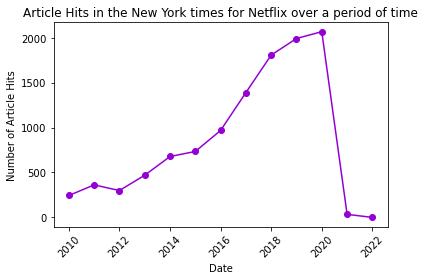

In [43]:
articles_df['Date'] = pd.to_datetime(articles_df['Date'])
articles_df.sort_values('Date', inplace=True)

articles_df['Articles'] = pd.to_numeric(articles_df['Articles'])

articles_df = articles_df.fillna(0)

plt.plot(articles_df[articles_df.columns[0]],articles_df[articles_df.columns[1]], color = "darkviolet", marker ="o")

plt.xlabel("Date")
plt.ylabel("Number of Article Hits")
plt.title(f"Article Hits in the New York times for {company} over a period of time")
plt.xticks(rotation = 45)

plt.tight_layout()
# Show the chart
plt.show()